In [ ]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse



Cannot get token. Quitting.


In [ ]:
!sudo apt-get install -qq w3m # to act as web browser
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 121754 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3+git20210102-6ubuntu0.2_amd64.deb ...
Unpacking w3m (0.5.3+git20210102-6ubuntu0.2) ...
Setting up w3m (0.5.3+git20210102-6ubuntu0.2) ...
Processing triggers for man-db (2.10.2-1) ...
/content
/content/drive
/content
/
Cannot get token. Quitting.


In [ ]:
input_image_path = "/content/drive/MyDrive/final-221123/Pre-trained Models/test-image1.jpg"
input_image = cv.imread(input_image_path)

In [ ]:
#Detect the faces in the input image

def getFace(faceDetectionModel, inputImage, conf_threshold=0.7):
  cpy_input_image = inputImage.copy() #To avoid modifications to the original input, taking copy of the given image in the function

  frameWidth = cpy_input_image.shape[1]
  frameHeight = cpy_input_image.shape[0]

  blob = cv.dnn.blobFromImage(cpy_input_image, scalefactor=1, size= (227, 227), mean=(104, 117, 123), crop=False) #preprocessed image

  faceDetectionModel.setInput(blob)
  detections = faceDetectionModel.forward()

  bounding_boxes = []
  for i in range(detections.shape[2]):  #detections is an array having [no.of.images/batch size, classes/channels, i-th detections, confidence_score]
    confidence_score = detections[0, 0, i, 2] #gets the confidence score for i-detections, 4-th index(value:2) shows confidence score

    if confidence_score > conf_threshold: #get the co-ordinates of the bounding boxes only if its detected as a face, confidence score sets the minimum limit
      x1 = int(detections[0,0,i,3] * frameWidth)
      y1 = int(detections[0,0,i,4] * frameHeight)
      x2 = int(detections[0,0,i,5] * frameWidth)
      y2 = int(detections[0,0,i,6] * frameHeight)
      bounding_boxes.append([x1, y1, x2, y2])

      cv.rectangle(cpy_input_image, (x1,y1), (x2,y2), color=(255, 0, 0), thickness=2)
  return cpy_input_image, bounding_boxes

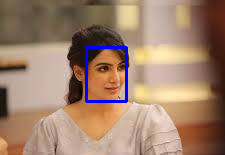

In [ ]:
#loading the face detection model
faceProto = "/content/drive/MyDrive/final-221123/Pre-trained Models/opencv_face_detector.pbtxt"
faceModel = "/content/drive/MyDrive/final-221123/Pre-trained Models/opencv_face_detector_uint8.pb"
faceNet = cv.dnn.readNet(faceModel, faceProto)

detected_image, bounding_boxes = getFace(faceNet, input_image) #assigns 2 variables to the returned values from getFace() function.

# Display the detected face image with bounding boxes
cv2_imshow(detected_image)

In [ ]:
#loading the gender detection pretrained model

genderProto = "//content/drive/MyDrive/final-221123/Pre-trained Models/gender_deploy.prototxt"
genderModel = "/content/drive/MyDrive/final-221123/Pre-trained Models/gender_net.caffemodel"
genderNet = cv.dnn.readNet(genderModel, genderProto)

genderList = ['Male', 'Female']

true_labels = []
predicted_labels = []

Predicted Gender: Female, Confidence Score: 0.8314807415008545



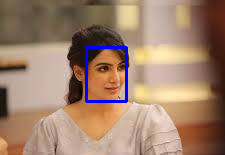

In [ ]:
  if not bounding_boxes:
    print("No faces detected in the image")
  else:
    for bounding_box in bounding_boxes:
      x1, y1, x2, y2 = bounding_box #assigns the bounding boxes coordinates to each x and y values
      detected_face_box = input_image[y1:y2, x1:x2]      #[start_row:end_row, start_column:end_column]; y-represents ROWS and x-represents COLUMNS

      detected_face_blob = cv.dnn.blobFromImage(detected_face_box,scalefactor=1, size=(227,227), mean=([78.4263377603, 87.7689143744, 114.895847746]), crop=False)

      genderNet.setInput(detected_face_blob)
      genderPrediction = genderNet.forward() #produces an output vector(list) with 2 elements in the list

      gender = genderList[genderPrediction[0].argmax()] #find the maximum array element and returns the index of that element in the specified axis. Here, 0 - as we have only one image

      print(f"Predicted Gender: {gender}, Confidence Score: {genderPrediction[0].max()}")

      true_labels.append("Female" if "female" in input_image_path.lower() else "Male")
      predicted_labels.append(gender)

print()
cv2_imshow(detected_image)

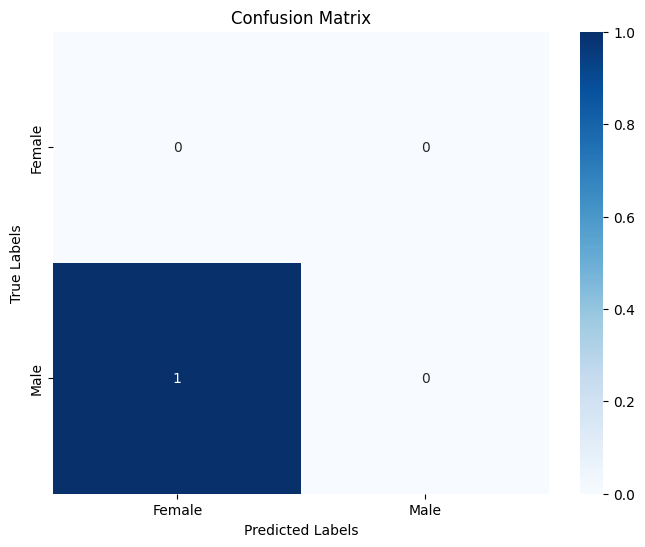

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()